# CALCULATE STANDARD TIMES - PART ONE

## Outline
+ This notebook imports a csv file of winning times recorded from horse racing results in the UK and Ireland 2000 - 2015.
+ The goal of the notebook is to calculate a standard time for each configuration of racecourse, racetype and distance.

In [224]:
# set up, imports and configuration
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# plt.rcParams['agg.path.chunksize'] = 10000
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.family'] = 'sans-serif'

## Getting the Data

In [225]:
# # Merging the .csv files was important in order to get easier access to related column fields
# # Wrapping the whole process in a function is nice because now I can run the notebook without calling this function
def merge_dfs(years = range(2000,2016)):
    for year in years:
        linksdf = pd.read_csv("/home/benjamin/Documents/form_study/data/timeform/csv/raw/links{}.csv".format(year))
        racesdf = pd.read_csv("/home/benjamin/Documents/form_study/data/timeform/csv/raw/races{}.csv".format(year))
        resultsdf = pd.read_csv("/home/benjamin/Documents/form_study/data/timeform/csv/raw/results{}.csv".format(year))
        racesdf.rename(columns={'age':'age_cond'}, inplace=True)
        races2df = pd.merge(linksdf, racesdf, how='outer', on="raceID")
        merged_df = pd.merge(races2df, resultsdf, how='outer', on="raceID")
        print year, merged_df.shape
        merged_df.to_csv("/home/benjamin/Documents/form_study/data/timeform/csv/merged/complete{}.csv".format(year))
    return
# merge_dfs()

## Cleaning the Data

In [226]:
# produce an aggregated file of all wintimes
def get_wintimes(years = range(2000,2016)):
    # create blank df
    wintimes = pd.DataFrame(columns=['raceID','racedate','racecourse','distance','going', 'raceclass','racetype','racetype2','age_cond','wintime'])    
    for year in years:
        # get each df
        completedf = pd.read_csv("/home/benjamin/Documents/form_study/data/timeform/csv/merged/complete{}.csv".format(year))
        # select columns and drop duplicates (lots due to no of runners in race with identical winning time)
        newdf = completedf[['raceID','racedate','racecourse','distance','going', 'raceclass','racetype','racetype2','age_cond','wintime']].drop_duplicates(subset=['raceID','wintime'])        
        # iteratively concatenate to st_df
        wintimes = pd.concat([wintimes, newdf])
    return wintimes
# wintimes = get_wintimes()
# wintimes.to_csv("/home/benjamin/Documents/form_study/data/timeform/csv/analysis/wintimes.csv", dtype = {'raceID': int, 'racedate': object, 'racecourse': int, 'distance': float, 'going': object, 'raceclass': object, 'racetype': object, 'racetype2': object, 'age_cond': object, 'wintime': float})

In [227]:
# Going has many useless categories. This code removes unneccesary going categories.
def remove_going_categories(wintimes):
    going_dict = ['standard','standard-slow','standard-fast','fast','slow','firm','good-firm','good','good-soft','soft','soft-heavy','heavy']
    wintimes = wintimes[wintimes.going.isin(going_dict)]
    return wintimes
# wintimes = remove_going_categories(wintimes)
# wintimes.going.value_counts()

In [228]:
# This code joins a few going categories together.
def join_going_categories(wintimes):
    di = {'standard-slow':'slow','standard-fast':'fast','soft-heavy':'heavy'}
    wintimes['going'] = wintimes['going'].apply(lambda x: di.get(x,x))
    return wintimes
# wintimes = join_going_categories(wintimes)
# wintimes.going.value_counts()

In [229]:
def improve_raceclass(wintimes):
    # for old letter based raceclass
    di = {'A':'1','B':'2','C':'3','D':'4','E':'5','F':'6','G':'6','H':'7','f':'6', 'h': '7','e': '5', '0': np.nan, 'NaN': np.nan}
    wintimes['raceclass'] = wintimes['raceclass'].apply(lambda x: di.get(x,x))
    wintimes.raceclass = wintimes.raceclass.astype(float)
    # len(wintimes)
    # wintimes.raceclass.value_counts()
    # wintimes['raceclass'] = wintimes['raceclass'].apply(lambda x: di.get(x,x))
    return wintimes
# wintimes = improve_raceclass(wintimes)
# wintimes.raceclass.value_counts()

In [230]:
# Write to csv file again
# wintimes.to_csv("/home/benjamin/Documents/form_study/data/timeform/csv/analysis/wintimes.csv")

In [231]:
# Read wintimes from csv file and call it something fresh like newframe
newframe = pd.read_csv("/home/benjamin/Documents/form_study/data/timeform/csv/analysis/wintimes.csv")
len(newframe)

170727

In [232]:
# Drop wintime NAs especially so that the percentile functions work
newframe = newframe.dropna(subset=['going', 'wintime'], how='any')
newframe.describe()

,Unnamed: 0,raceID,racecourse,distance,raceclass,wintime
count,170581.000000,1.705810e+05,170581.000000,170581.000000,135947.000000,170581.000000
mean,57567.306365,3.437097e+10,69.820941,13.169629,4.384510,189.990310
std,34247.939257,4.413052e+10,74.606599,6.353162,1.357325,107.750126
min,0.000000,1.110001e+09,1.000000,0.000000,1.000000,0.010000
25%,27585.000000,1.231050e+10,23.000000,7.040000,NaN,90.480000
50%,57177.000000,1.411091e+10,41.000000,12.000000,NaN,156.690000
75%,85627.000000,1.581150e+10,58.000000,18.000000,NaN,274.350000
max,131798.000000,1.601081e+11,229.000000,36.000000,7.000000,660.060000


In [233]:
# 170,000 individual wintimes (i.e. 170,000 races) from 15 years of racing is pretty good.
newframe.shape

(170581, 11)

In [234]:
newframe.head()

,Unnamed: 0,raceID,racedate,racecourse,distance,going,raceclass,racetype,racetype2,age_cond,wintime
0,0,1.110001e+09,2000-01-15,1.0,20.0,good-soft,3.0,Novices' Hurdle,Hurdle,5yo+,324.91
1,7,1.110001e+09,2000-01-15,1.0,19.5,good-soft,2.0,Handicap Chase,Chase,5yo+,309.59
2,12,1.110001e+09,2000-01-15,1.0,16.0,good-soft,1.0,Handicap Chase,Chase,5yo+,244.63
3,22,1.110001e+09,2000-01-15,1.0,16.5,good-soft,2.0,Handicap Hurdle,Hurdle,4yo+,255.31
4,29,1.110001e+09,2000-01-15,1.0,24.5,good-soft,2.0,Novices' Chase,Chase,5yo+,398.33


In [235]:
newframe.tail()

,Unnamed: 0,raceID,racedate,racecourse,distance,going,raceclass,racetype,racetype2,age_cond,wintime
170722,115035,1.222115e+11,2015-12-31,222.0,16.0,heavy,NaN,Novices' Hurdle,Hurdle,3yo,257.5
170723,115045,1.222115e+11,2015-12-31,222.0,24.0,heavy,NaN,Novices' Hurdle (Grade 2),Hurdle,4yo+,373.6
170724,115051,1.222115e+11,2015-12-31,222.0,20.0,heavy,NaN,Handicap Hurdle,Hurdle,4yo+,334.9
170725,115059,1.222115e+11,2015-12-31,222.0,16.0,heavy,NaN,Amateur Riders' Handicap Hurdle,Hurdle,4yo+,261.5
170726,115071,1.222115e+11,2015-12-31,222.0,18.0,heavy,NaN,Maiden National Hunt Flat,National Hunt Flat,4yo,284.8


I've absolutely no fucking idea after three years of trying to work this out how to do this.

## Visualising the Data

+ The first scatter plot (below) graphs all the winning times in the dataframe.
+ Distance (in furlongs) is plotted on the x-axis against wintime (in seconds) on the y-axis.

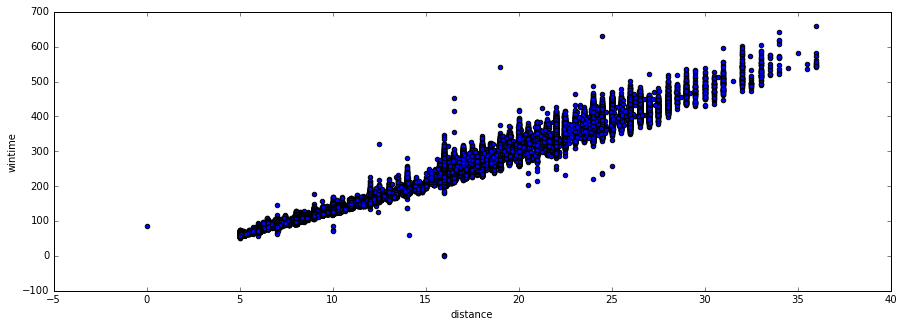

In [236]:
newframe.plot(kind='scatter', x='distance', y='wintime')

## Removing Outliers

+ A tortuous method which has nearly wiped me out but compare the scatter plot below to that above.
+ Outliers have been removed from the wintimes.

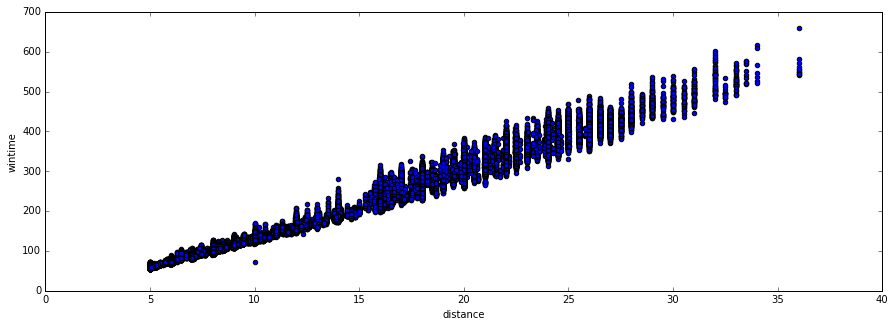

In [237]:
statsdf = newframe.groupby(['racecourse','racetype2','distance']).wintime.agg(['mean', 'std','count']).reset_index()
statsdf.head()
wintimes = pd.merge(newframe, statsdf, how='left', on=['racecourse','racetype2','distance'])
# len(s1) # 170581 as newframe above
wintimes = wintimes.dropna(subset=['mean', 'std', 'wintime', 'count'], how='any')
# len(s1) # 170386 rows after nas dropped from relevant columns 
wintimes['stdx3'] = wintimes['std'] * 3
wintimes['windiff'] = abs(wintimes['wintime'] - wintimes['mean'])
wintimes = wintimes[wintimes.windiff < wintimes.stdx3]
# len(s1) # 169137 rows after outliers are removed. Removed 1249 outliers which is 0.007% of the total wintimes.
wintimes.drop(['windiff','stdx3','mean','std'], axis=1, inplace=True)
wintimes = wintimes[(wintimes['count'] > 5)]
# len(s1) # 167966 rows after rows where number of races is less than 5 dropped
wintimes.plot(kind='scatter', x='distance', y='wintime')

## The Effect of Distance on Racetimes

With outliers removed from the data, I now calculate the mean wintime for each configuration of racecourse, racetype and distance.

In [238]:
def get_means(x):
    result = {'distance_count': x['distance'].count(), 'wintime_mean': x['wintime'].mean()}
    return pd.Series(result, name='metrics')

times_by_dist = wintimes.groupby(['racecourse','racetype2','distance']).apply(get_means).reset_index()
times_by_dist.head()

metrics,racecourse,racetype2,distance,distance_count,wintime_mean
0,1.0,Chase,16.0,24.0,242.108750
1,1.0,Chase,17.0,54.0,254.020556
2,1.0,Chase,19.0,42.0,286.277857
3,1.0,Chase,19.5,43.0,303.526279
4,1.0,Chase,21.5,44.0,324.491818


I calculate the coefficients between distance and the mean wintime. Coefficients range from 0 to 1. A coefficient between 0.95 and 1.00 indicates statistical significance and that the two variables (distance and final racetime) are likely to be correlated. The NH Flat coefficient is a bit worrying and suggests there may be some errors in the data.

In [239]:
# compute correlation coefficients
# Series.corr(other, method='pearson', min_periods=None)
flt_corr = times_by_dist[times_by_dist.racetype2 == 'Flat'].distance.corr(times_by_dist.wintime_mean, method='pearson', min_periods=None)
hdl_corr = times_by_dist[times_by_dist.racetype2 == 'Hurdle'].distance.corr(times_by_dist.wintime_mean, method='pearson', min_periods=None)
nhf_corr = times_by_dist[times_by_dist.racetype2 == 'National Hunt Flat'].distance.corr(times_by_dist.wintime_mean, method='pearson', min_periods=None)
chs_corr = times_by_dist[times_by_dist.racetype2 == 'Chase'].distance.corr(times_by_dist.wintime_mean, method='pearson', min_periods=None)
print 'Flat    Correlation between Distance and Mean Wintime:', flt_corr
print 'Chase   Correlation between Distance and Mean Wintime:', chs_corr
print 'Hurdle  Correlation between Distance and Mean Wintime:', hdl_corr
print 'NH Flat Correlation between Distance and Mean Wintime:', nhf_corr

Flat    Correlation between Distance and Mean Wintime: 0.995371693804
Chase   Correlation between Distance and Mean Wintime: 0.986606760758
Hurdle  Correlation between Distance and Mean Wintime: 0.980183171911
NH Flat Correlation between Distance and Mean Wintime: 0.937014835162


+ The scatter plot (below) graphs means of winning times for each type of race (chase, hurdle, nh flat, flat).

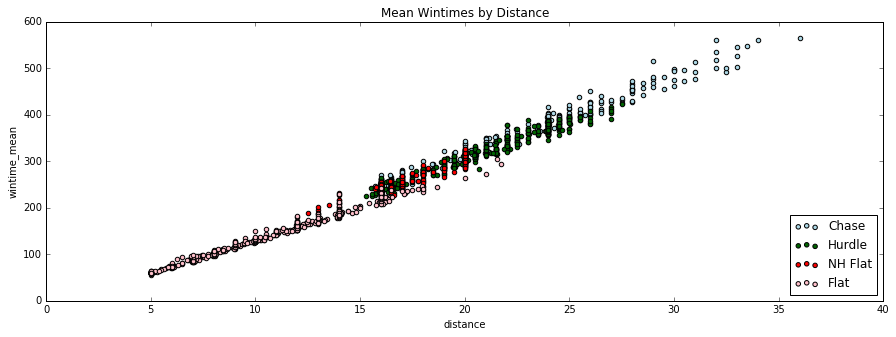

In [240]:
ax = times_by_dist[times_by_dist.racetype2=='Chase'].plot.scatter(x='distance', y='wintime_mean', color='LightBlue', label='Chase');
times_by_dist[times_by_dist.racetype2=='Hurdle'].plot.scatter(x='distance', y='wintime_mean', color='DarkGreen', label='Hurdle', ax=ax);
times_by_dist[times_by_dist.racetype2=='National Hunt Flat'].plot.scatter(x='distance', y='wintime_mean', color='Red', label='NH Flat', ax=ax); 
times_by_dist[times_by_dist.racetype2=='Flat'].plot.scatter(x='distance', y='wintime_mean', color='Pink', label='Flat', ax=ax, title="Mean Wintimes by Distance")
ax.legend(loc='lower right')

+ The scatter plot (below) graphs the mean winning times recorded at different distances for Ascot racecourse (flat racing only). 

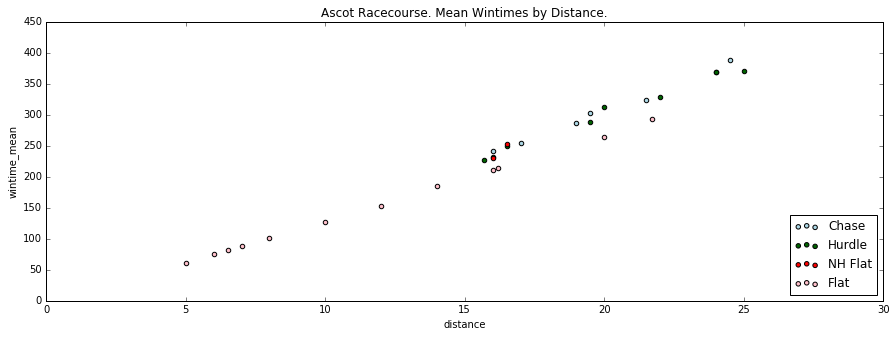

In [241]:
ax = times_by_dist[(times_by_dist.racetype2=='Chase') & (times_by_dist.racecourse==1.0)].plot.scatter(x='distance', y='wintime_mean', color='LightBlue', label='Chase');
times_by_dist[(times_by_dist.racetype2=='Hurdle') & (times_by_dist.racecourse==1.0)].plot.scatter(x='distance', y='wintime_mean', color='DarkGreen', label='Hurdle', ax=ax);
times_by_dist[(times_by_dist.racetype2=='National Hunt Flat') & (times_by_dist.racecourse==1.0)].plot.scatter(x='distance', y='wintime_mean', color='Red', label='NH Flat', ax=ax); 
times_by_dist[(times_by_dist.racetype2=='Flat') & (times_by_dist.racecourse==1.0)].plot.scatter(x='distance', y='wintime_mean', color='Pink', label='Flat', ax=ax, title="Ascot Racecourse. Mean Wintimes by Distance.")
ax.legend(loc='lower right')

## The Effect of Going on Racetimes

I use an almost identical method to calculate the mean racetimes by type of going conditions.
In order to plot the data, I first have to convert the different going categories into a sequence of numbers.

In [242]:
#' replace goings with numbered dict
goingDict = {'fast': 1, 'firm': 2, 'good-firm': 3, 'standard': 4, 'good': 5, 'good-soft': 6, 'slow': 7, 'soft': 8 ,'heavy': 9 }
goingtimes = wintimes.replace({"going": goingDict})
# goingtimes.head()

def get_means(x):
    result = {'going_count': x['going'].count(), 'wintime_mean': x['wintime'].mean()}
    return pd.Series(result, name='g_metrics') 
times_by_going = goingtimes.groupby(['distance','racetype2','going']).apply(get_means).reset_index()
times_by_going.head()

g_metrics,distance,racetype2,going,going_count,wintime_mean
0,5.0,Flat,1,359.0,59.113705
1,5.0,Flat,2,466.0,59.604893
2,5.0,Flat,3,2100.0,60.098067
3,5.0,Flat,4,1608.0,60.092083
4,5.0,Flat,5,1479.0,60.699966


I calculate correlation coefficients between wintimes and going type.  
Is there a correlation? In reality, yes there is. Going will slow the final racetime.  
It doesn't really show up here. I don't really understand the statistics I'm messing with.

In [243]:
# compute correlation coefficients
# Series.corr(other, method='pearson', min_periods=None)
flt_corr = times_by_going[times_by_going.racetype2 == 'Flat'].going.corr(times_by_going.wintime_mean, method='pearson', min_periods=None)
hdl_corr = times_by_going[times_by_going.racetype2 == 'Hurdle'].going.corr(times_by_going.wintime_mean, method='pearson', min_periods=None)
nhf_corr = times_by_going[times_by_going.racetype2 == 'National Hunt Flat'].going.corr(times_by_going.wintime_mean, method='pearson', min_periods=None)
chs_corr = times_by_going[times_by_going.racetype2 == 'Chase'].going.corr(times_by_going.wintime_mean, method='pearson', min_periods=None)
print 'Flat    Correlation between Going and Mean Wintime:', flt_corr
print 'Chase   Correlation between Going and Mean Wintime:', chs_corr
print 'Hurdle  Correlation between Going and Mean Wintime:', hdl_corr
print 'NH Flat Correlation between Going and Mean Wintime:', nhf_corr

Flat    Correlation between Going and Mean Wintime: 0.048373324439
Chase   Correlation between Going and Mean Wintime: 0.191786179499
Hurdle  Correlation between Going and Mean Wintime: 0.223427094969
NH Flat Correlation between Going and Mean Wintime: 0.273239246687


+ The bar plot (below) graphs mean wintimes at a selection of distances (flat racing only).
+ It fails to visually highlight the impact of going in increasing racetime. 

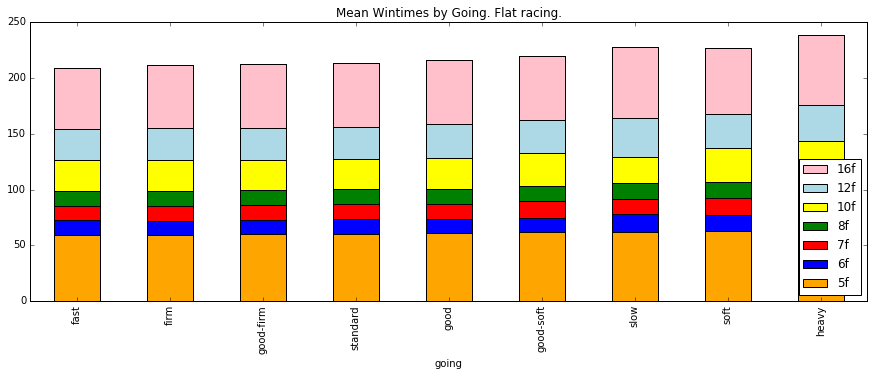

In [244]:
ax = times_by_going[(times_by_going.racetype2=='Flat') & (times_by_going.distance==16.0)].plot.bar(x='going',y='wintime_mean', color='DarkGreen', label = '')
times_by_going[(times_by_going.racetype2=='Flat') & (times_by_going.distance==16.0)].plot.bar(x='going',y='wintime_mean', color='Pink', ax=ax, label='16f')
times_by_going[(times_by_going.racetype2=='Flat') & (times_by_going.distance==12.0)].plot.bar(x='going',y='wintime_mean', color='LightBlue', ax=ax, label='12f')
times_by_going[(times_by_going.racetype2=='Flat') & (times_by_going.distance==10.0)].plot.bar(x='going',y='wintime_mean', color='Yellow', ax=ax, label='10f')
times_by_going[(times_by_going.racetype2=='Flat') & (times_by_going.distance==8.0)].plot.bar(x='going',y='wintime_mean', color='Green', ax=ax, label='8f')
times_by_going[(times_by_going.racetype2=='Flat') & (times_by_going.distance==7.0)].plot.bar(x='going',y='wintime_mean', color='Red', ax=ax, label='7f')
times_by_going[(times_by_going.racetype2=='Flat') & (times_by_going.distance==6.0)].plot.bar(x='going',y='wintime_mean', color='Blue', ax=ax, label='6f')
times_by_going[(times_by_going.racetype2=='Flat') & (times_by_going.distance==5.0)].plot.bar(x='going',y='wintime_mean', color='Orange', ax=ax, label='5f')
ax.set_xticklabels(['fast', 'firm', 'good-firm', 'standard', 'good', 'good-soft', 'slow', 'soft','heavy'])
ax.set_title('Mean Wintimes by Going. Flat racing.')
ax.legend(loc='lower right')

+ The bar plot below effectively hones in on a sub-section of the 6 furlong bars plotted above.
+ The y-axis shows only the range between 70 and 80 seconds for final times. This makes the effect of going more striking.

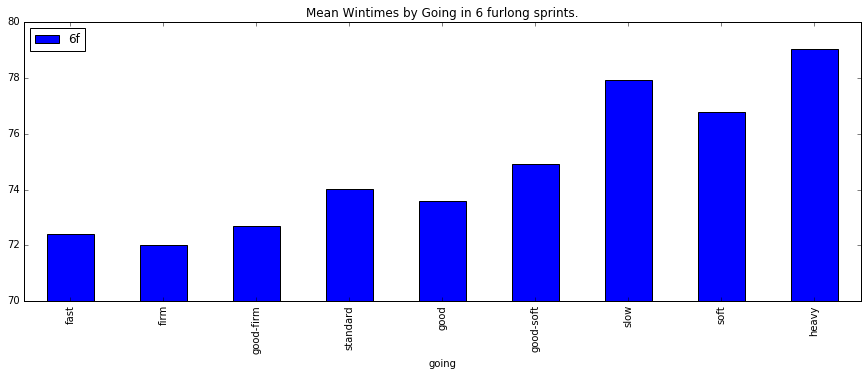

In [245]:
ax = times_by_going[(times_by_going.racetype2=='Flat') & (times_by_going.distance==6.0)].plot.bar(x='going',y='wintime_mean', color='Blue', label = '6f')
ax.set_xticklabels(['fast', 'firm', 'good-firm', 'standard', 'good', 'good-soft', 'slow', 'soft','heavy'])
ax.set_ylim(70,80)
ax.set_title('Mean Wintimes by Going in 6 furlong sprints.')

## The Effect of Class on Racetimes

I use the same method again to calculate mean wintimes for each class of race.
First I have to sort out raceclass which is taking some time.

In [246]:
def get_means(x):
    result = {'class_count': x['raceclass'].count(), 'wintime_mean': x['wintime'].mean()}
    return pd.Series(result, name='c_metrics') 
times_by_class = wintimes.groupby(['distance','racetype2','raceclass']).apply(get_means).reset_index()
times_by_class.head()

c_metrics,distance,racetype2,raceclass,class_count,wintime_mean
0,5.0,Flat,1.0,298.0,59.586544
1,5.0,Flat,2.0,371.0,59.767790
2,5.0,Flat,3.0,578.0,60.094221
3,5.0,Flat,4.0,1508.0,60.757918
4,5.0,Flat,5.0,2302.0,60.980760


I am not anticipating that much of a correlation will show up between racetime and raceclass since, primarily, distance and, secondly, going impact much more on final race times.   

In [247]:
# compute correlation coefficients
# Series.corr(other, method='pearson', min_periods=None)
flt_corr = times_by_class[times_by_class.racetype2 == 'Flat'].raceclass.corr(times_by_class.wintime_mean, method='pearson', min_periods=None)
hdl_corr = times_by_class[times_by_class.racetype2 == 'Hurdle'].raceclass.corr(times_by_class.wintime_mean, method='pearson', min_periods=None)
nhf_corr = times_by_class[times_by_class.racetype2 == 'National Hunt Flat'].raceclass.corr(times_by_class.wintime_mean, method='pearson', min_periods=None)
chs_corr = times_by_class[times_by_class.racetype2 == 'Chase'].raceclass.corr(times_by_class.wintime_mean, method='pearson', min_periods=None)
print 'Flat    Correlation between Class and Mean Wintime:', flt_corr
print 'Chase   Correlation between Class and Mean Wintime:', chs_corr
print 'Hurdle  Correlation between Class and Mean Wintime:', hdl_corr
print 'NH Flat Correlation between Class and Mean Wintime:', nhf_corr

Flat    Correlation between Class and Mean Wintime: 0.0263194104227
Chase   Correlation between Class and Mean Wintime: -0.00187098930012
Hurdle  Correlation between Class and Mean Wintime: 0.125548663164
NH Flat Correlation between Class and Mean Wintime: 0.0200297426262


+ The bar plot (below) graphs mean wintimes for each class of race (flat racing only).
+ It fails to visually highlight the impact of class on racetime.

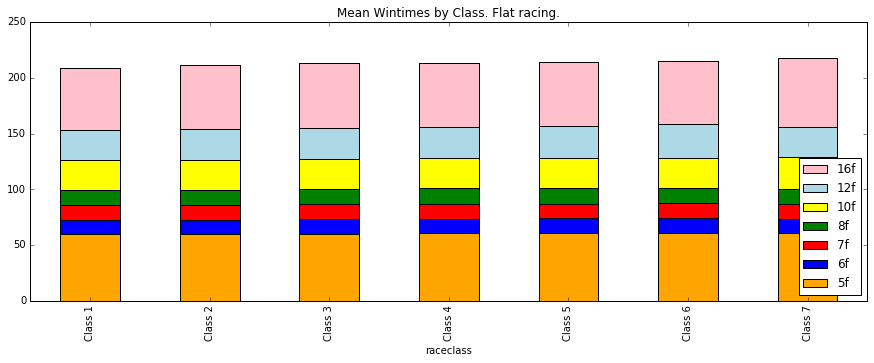

In [248]:
ax = times_by_class[(times_by_class.racetype2=='Flat') & (times_by_class.distance==16.0)].plot.bar(x='raceclass',y='wintime_mean', color='DarkGreen', label = '')
times_by_class[(times_by_class.racetype2=='Flat') & (times_by_class.distance==16.0)].plot.bar(x='raceclass',y='wintime_mean', color='Pink', ax=ax, label='16f')
times_by_class[(times_by_class.racetype2=='Flat') & (times_by_class.distance==12.0)].plot.bar(x='raceclass',y='wintime_mean', color='LightBlue', ax=ax, label='12f')
times_by_class[(times_by_class.racetype2=='Flat') & (times_by_class.distance==10.0)].plot.bar(x='raceclass',y='wintime_mean', color='Yellow', ax=ax, label='10f')
times_by_class[(times_by_class.racetype2=='Flat') & (times_by_class.distance==8.0)].plot.bar(x='raceclass',y='wintime_mean', color='Green', ax=ax, label='8f')
times_by_class[(times_by_class.racetype2=='Flat') & (times_by_class.distance==7.0)].plot.bar(x='raceclass',y='wintime_mean', color='Red', ax=ax, label='7f')
times_by_class[(times_by_class.racetype2=='Flat') & (times_by_class.distance==6.0)].plot.bar(x='raceclass',y='wintime_mean', color='Blue', ax=ax, label='6f')
times_by_class[(times_by_class.racetype2=='Flat') & (times_by_class.distance==5.0)].plot.bar(x='raceclass',y='wintime_mean', color='Orange', ax=ax, label='5f')
ax.set_xticklabels(['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7'])
ax.set_title('Mean Wintimes by Class. Flat racing.')
ax.legend(loc='lower right')

+ The bar plot below effectively hones in on a sub-section of the 6 furlong bars plotted above.
+ The y-axis shows only the range between 70 and 80 seconds for final times. This makes the effect of class more striking.

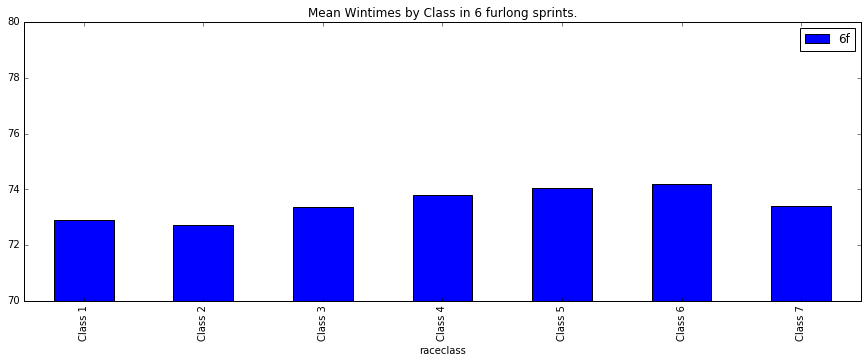

In [249]:
ax = times_by_class[(times_by_class.racetype2=='Flat') & (times_by_class.distance==6.0)].plot.bar(x='raceclass',y='wintime_mean', color='Blue', label = '6f')
ax.set_xticklabels(['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7'])
ax.set_ylim(70,80)
ax.set_title('Mean Wintimes by Class in 6 furlong sprints.')

## Concluding Thoughts

+ That was very hard work and in the end the notebook doesn't look too bad.
+ I have learned little about horse racing from this study.
+ I have learned that the underlying data is not wholly reliable. It looks just about tidy enough to continue to work with.
+ I have not fulfilled my objective of calculating standard times. This will wait for a new notebook.
+ See calculate_standard_times_part_two!

## Updated: 21.06.2016     |     Authored : hullboy73